In [1]:
#!pip install matplotlib-label-lines

In [2]:
import platform 
import os, time
# dictionary 
info = {} 
  
platform_details = platform.platform() 
info["platform details"] = platform_details 
system_name = platform.system() 
info["system name"] = system_name 
processor_name = platform.processor() 
info["processor name"] = processor_name 
architecture_details = platform.architecture() 
info["architectural detail"] = architecture_details 
for i, j in info.items(): 
    print(i, " - ", j) 

print(os.getcwd())

platform details  -  Windows-10-10.0.19041-SP0
system name  -  Windows
processor name  -  Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
architectural detail  -  ('64bit', 'WindowsPE')
C:\Users\sd\notebooks\MAIN_PRJWindows\AddConstToObj


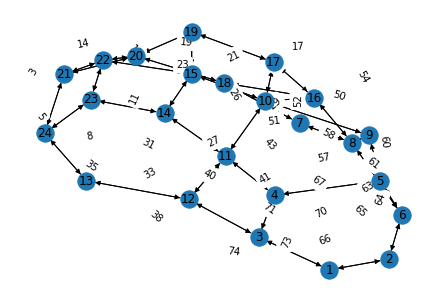

C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [3]:
from datetime import datetime
import networkx as nx
import sqlite3 
import os
import sys
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
from labellines import labelLines

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sdNetworkUtility  import *
from sdTapPyomo  import *
from sdLIPSolverAddConstToObj  import *
#----------------------------------
np. set_printoptions(threshold=np. inf)


#در ساختار شبکه در جدول نودها فرض شده که نودهایی که می توانند مبدا یا مقصد یک زوج مبدا مقصد باشند(زون هستند)در همان ابندای جدول و از اندیس
#1 - n
#آمده اند و فیلد 
#is_OD 
#آنها 1 است
# Create a SQL connection to our SQLite database               # 9Nodes  SiouxFalls Anaheim
con = sqlite3.connect("C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment/1_project/SiouxFalls/project_database.sqlite")
cur = con.cursor()
G = nx.DiGraph()
#مشخص کردن تعداد ODها
cur.execute('SELECT count(is_OD) FROM nodes where is_OD = 1 ')
Data= cur.fetchall()
NodeODCount =Data[0][0] #تعداد نودهایی که مبدا یا مقصد هستند(زون هستند) 
ODCount = NodeODCount**2
#-------------
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data: #---We use free_flow_time As weight of edges for compute K-Shortest path
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
#----------رسم گراف شبکه----

sdDrawGraph(nx,G)

ODNumber_Matrix = sdGet_ODNumber_Matrix(NodeODCount)
n,m = np.shape(ODNumber_Matrix)

# تقاضا بین زوجها
ODDeman_Matrix = pd.read_excel(r'C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment/0_tntp_data/SiouxFalls/xod.xlsx',sheet_name='Sheet1')
ODDeman_Vector = np.zeros(ODCount) 
for i in range(n):
     for j in range(m):
        ODDeman_Vector[ODNumber_Matrix[i,j] - 1] = ODDeman_Matrix.iloc[i,j]

#--تعریف ساختمان داده های لازم
#لیست تمام یالهای گراف را میدهد اما نامرتب
edgs = list(G.edges(data=True))

#مرتب کردن یالها بر اساس شماره لینک
LinksList =  list(np.zeros(len(edgs)))
for row in edgs:
    LinksList[row[2]['link_id'] -1] = row
 
 
#فقط برای نودهای مبدا-مقصد که در اول لیست نودها هم هستند کوتاهترین مسیرها محاسبه می شود
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,7,NodeODCount)

        #ماتریس تعیین عضویت هر زوج در هر مسیر
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)

#P_i: set of paths between origin-destination in I
LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )

LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
        



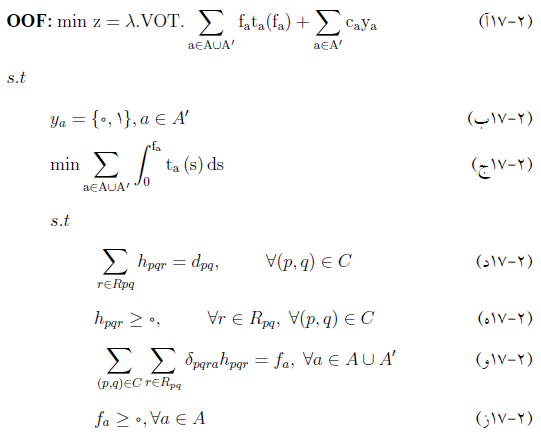

In [4]:
#--Calculate High Level Objective Function
# free Flow Time به دقیقه
#زمان سفر کل بر حسب دقیقه در روز
#ظرفیت  بر حسب تعداد خودرو در روز
#جریان  بر حسب تعداد خودرو در روز
# تعداد خودرو در روز تقاضای سفر بر حسب

def CalcZ(intObjectiveFunc,X,Capacity,Tzero,Cost,linksY, Min1=0,Max1=0,Min2 = 0,Max2=0, Landa= 1):
    #ایران
    #GDP = 2282 * 280000  #ریال
    #TW = 365 * 8
    #VOT = GDP / TW  ارزش یک ساعت کار
   #------------------
    #آمریکا
    GDP = 63543  #دلار
    TW = 365 * 5 # 
    VOT = GDP / TW  #  ارزش یک ساعت کار
    VOT = VOT / 60 #ارزش یک دقیقه کار
    if intObjectiveFunc == 1: #فقط زمان سفر کل
        return sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) )
    elif intObjectiveFunc == 2: #فقط هزینه ساخت
        return sum(Cost[z] * linksY[z] for z in range(len(Cost)))
    elif intObjectiveFunc == 3: #  در رنج 1 هر دو
        C1 = Max1 - Min1
        C2 = Max2 - Min2
        return ( Landa * (((sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) ) ) - Min1) /C1)  + ( (sum(Cost[z] * linksY[z] for z in range(len(Cost))) - Min2) / C2) )  
    elif intObjectiveFunc == 4: # هر دو
        return ( Landa * VOT * (((sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) ) ) ))  + ( (sum(Cost[z] * linksY[z] for z in range(len(Cost))) ) ) )  
    

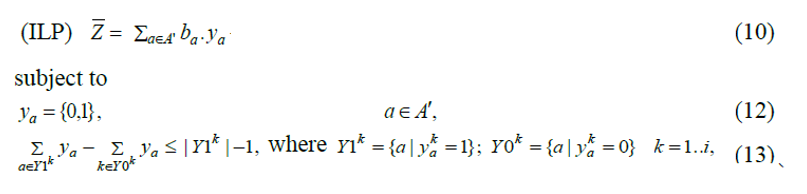

In [5]:
def CalcZBar(linksY,Ba):
    return sum(linksY[z] * Ba[z] for z in range(len(linksY)))
 

In [6]:
PrgStartTime = datetime.now()
print('Program Satrt Time: '+ PrgStartTime.strftime('%X'))

TedadTekrar = 100

Landa = 5

TAPRuningTimeAll = []
LinearRegressionRuningTimeAll = []
LIPRuningTimeAll = []
Zbar_Matrix = []
#Anaheim
#NewLinkIds = np.array([636,719, 771,718])# ,665,699, 414,451, 428,483])
#NewLinkCost = np.array([4 * 10**9, 5 * 10**9, 7 * 10**9, 8 * 10**9])#, 58 * 10**9,44 * 10**9, 59 * 10**9, 79 * 10**9, 86 * 10**9, 58 * 10**9])


#SiouxFalls
NewLinkIds = np.array([1,3, 12,15 ,33,36, 47,46, 50])#,55])
NewLinkCost = np.array([2.4 * 10**6, 2.4 * 10**6, 2.1 * 10**6, 2.1 * 10**6, 2.2 * 10**6,2.2 * 10**6, 1.9 * 10**6, 1.9 * 10**6, 1.8 * 10**6])#, 1.8 * 10**6])

#9Nodes
#NewLinkIds = np.array([4,6,9,12,14,20]) 
#NewLinkCost = np.array([8 * 10**3, 4 * 10**3,9 * 10**3,7 * 10**3,6 * 10**3,6.5 * 10**3])

#---ابتدا با در با فرض اینکه تمام لینکها احداث شده اند و تابع هدف سطح بالا فقط عبارت اول که همان زمان سفر کل است را دارد،جریانها و زمان سفر کل را حساب می کنیم تا مقدار مینیمم زمان سفر نهایی را حساب کنیم
#-- از این مقدار و مقدار ماکزیمم زمان سفر نهایی که بعدا محاسبه می کنیم برای نرمال کردن عبارت زمان سفر نهایی در تابع هدف دو عبارتیمان استفاده میکنیم
###############محاسبه مقدار مینیمم زمان سفر کل###########################
# گرافی می سازیم که شامل تمام لینکهای جدید هم می شود و  از  همان اطلاعات برای محاسبه مقدار مینیمم زمان سفر کل استفاده میکنیم
# ساخت مجدد شبکه و اطلاعات لازم
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data:
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
LinksList = list(G.edges(data=True))
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,7,NodeODCount)
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 

        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)
LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )
LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]
LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]

ytmp =  np.array([[1] * len(NewLinkIds)])    
#flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
####Minimum of TotalTravelTime Occured when all y are 1
#MinTotalTravelTime = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,ytmp[0][:len(ytmp[0])]) 
#MaxCostForNewLinks = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,ytmp[0][:len(ytmp[0])]) 
#print('MinTotalTravelTime = ', MinTotalTravelTime)

########################################

#حذف لینکهای جدید از شبکه برای آماده کردن شبکه
strLinksForRemove = '-1'
for lkid in NewLinkIds:
    strLinksForRemove = strLinksForRemove + ',' + str(lkid)
#---دور اول ---
y =  np.array([[0] * len(NewLinkIds)])#انداره y  لینکهای جدید به تعداد
    
# ساخت مجدد شبکه و اطلاعات لازم
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links where link_id not in ('+ strLinksForRemove + ' ) order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data:
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
LinksList = list(G.edges(data=True))
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,7,NodeODCount)
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)


LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )
#total flow on the path k in P_ij = _fijk         جریان در کاامین مسیر از زوج آی و جی

LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
#-------------------------------
   
#sdDrawGraph(nx,G)

#---Solve TAP and calculate flows---
flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
#print('flows',flows)

#Maximum of TotalTravelTime Occured when all y are 0
#MaxTotalTravelTime = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])]) 
#MinCostForNewLinks = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])]) 

#print('MaxTotalTravelTime = ', MaxTotalTravelTime)
print('y = ',y)
#z1 = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
#z2 = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
#print("z1 = ",z1)
#print("z2 = ",z2)

#---Calculate z base on flows---
z = CalcZ(4,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])],0,0
          ,0,0, Landa)
#--چون تمام لینکها صفر هستند پس مقدار زدبار صفر می شود
Zbar = 0
Zbar_Matrix.append(Zbar)

print('z',z)
# ---Adding Curent z To Z vector---
Z = np.array( [z])
#print('Z',Z)

#========REGRESSION===========

#--اگر بخواهیم در تابع خطی و رگرسیون جمله مربوط به هزینه ها باشد باید این قسمت کد برای محاسبه
#B_bar
#فعال شود
#---Cailculate B_bar multiple-------
c = NewLinkCost 
#T = 0
#for i in range(len(y[0])):
#    T += c[i]*y[0][i]
#--Adding Current y To Y Matrix

#Y= np.array([np.append(y,T)])
Y= np.array(y)
X_train = Y
Y_train = Z
print('Y = ',Y)

#print('X_train',X_train)
#print('Y_train',Y_train)

model = LinearRegression()
model.fit(X_train, Y_train)

ModelCoef = np.array([model.coef_])

print('model.coef_, intercept_',model.coef_,model.intercept_)
#print('ModelCoef',ModelCoef)

b=model.coef_[0:len(NewLinkIds)]
#print('b',b)

#B_bar = model.coef_[len(NewLinkIds)]
Last_y = y[0]
#print('Param: ',c, b,Last_y )

#y = sdLIPSolve(c,b,B_bar,Y,'glpk')
y = sdLIPSolve(c,b,Y,'glpk')

MainloopStartTime = datetime.now()

print('MainLoop Satrt Time: '+ MainloopStartTime.strftime('%X'))
#---حلقه اصلی برنامه----

for Idx in range(TedadTekrar):#Main Loop
        print('====================================== ')
        print('شماره تکرار = ', Idx +1 )
        print('y = ',y )
        #---Create Network Base  On current y---
        strLinksForRemove = '-1'
        for i in range(len(y[0])):
            if y[0][i] == 0:
                strLinksForRemove = strLinksForRemove + ',' + str(NewLinkIds[i])
                
        #DrawNetwork(prj)
       #---ساخت مجدد شبکه با اعمال تغییرات لینکها 
        cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links where link_id not in ('+ strLinksForRemove + ' ) order by link_id ')
        Data= cur.fetchall()
        G.clear()
        for row in Data:
            G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
        LinksList = list(G.edges(data=True))
        All_KshortestPathList = sdGetAll_KshortestPath(nx,G,7,NodeODCount)
        DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
                #ماتریس تعیین عضویت هر لینک در هر مسیر
        DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)

        #P_i: set of paths between origin-destination in I
        LinkCount = len(LinksList) 
        PathCount = len(All_KshortestPathList )
       

        LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

        LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
        #-------------------------------
        
        #---Solve TAP and calculate flows---
        TAPStartTime = datetime.now()
        flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
        #print('flows',flows)
        TAPFinishTime = datetime.now()
        print('TAPRuningTime: ', TAPFinishTime - TAPStartTime)  
        TAPRuningTimeAll.append((TAPFinishTime - TAPStartTime).total_seconds())
        #---Calculate z base on flows---

        #z1 = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
        #z2 = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
        #print("z1 = ",z1)
        #print("z2 = ",z2)

        
        z = CalcZ(4,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])],0,0
                  ,0,0, Landa )
        # ---Adding Curent z To Z vector---
        Z = np.append(Z,[z], axis = 0) 

        #========REGRESSION===========
        
        Y_train = Z
        c = NewLinkCost 

    #--اگر بخواهیم در تابع خطی و رگرسیون جمله مربوط به هزینه ها باشد باید این قسمت کد برای محاسبه
    #B_bar
    #فعال شود
    #---Cailculate B_bar multiple-------
        #T = 0
        #for i in range(len(y[0]) ):
        #    T += c[i]*y[0][i]
        #--Adding Current y To Y Matrix
        #Y= np.append(Y, [np.append(y,T)], axis = 0)
        Y= np.append(Y, y, axis = 0)
        ModelCoef = np.append(ModelCoef, [model.coef_], axis = 0)

        #print("Y", Y)

        X_train = Y 
        
        #print('X_train',X_train)
       # print('Y_train',Y_train)
        LinearRegressionStartTime = datetime.now()
        model = LinearRegression()
        model.fit(X_train, Y_train)
        LinearRegressionFinishTime = datetime.now()
        print('LinearRegressionRuningTime: ', LinearRegressionFinishTime - LinearRegressionStartTime)  
        LinearRegressionRuningTimeAll.append((LinearRegressionFinishTime - LinearRegressionStartTime).total_seconds())
        
        print('model.coef_',model.coef_)
      #  print('ModelCoef',ModelCoef)

        b=model.coef_[:len(NewLinkIds)]

        Zbar = CalcZBar(y[0],b)
        Zbar_Matrix.append(Zbar)
        
        #print('b',b)
        #B_bar = model.coef_[len(NewLinkIds)]
        Last_y = y[0]
        #y = sdLIPSolve(c,b,B_bar,Y,'glpk')
        LIPStartTime = datetime.now()
        y = sdLIPSolve(c,b,Y,'glpk')
        LIPFinishTime = datetime.now()
        print('LIPRuningTime: ', LIPFinishTime - LIPStartTime)  
        LIPRuningTimeAll.append((LIPFinishTime - LIPStartTime).total_seconds())

        #print('Param: c, b,y,z',c, b,B_bar,y,z )
        #print('c = ', c )
        print('b = ',b )
        print('z = ',z )
        print('Zbar = ',Zbar)
        #print('Y = ', Y )
        #print('Z = ', Z )
        print('****************************************************************************************')

print('********************************************')
print('********************************************')
MainloopFinishTime = datetime.now()
print('MainloopFinishTime: ', MainloopFinishTime.strftime('%X'))  
print('MainloopRuningTime: ', MainloopFinishTime - MainloopStartTime)  


PrgFinishTime = datetime.now()
print('PrgFinishTime: ', PrgFinishTime.strftime('%X'))  
print('ProgramRuningTime: ', PrgFinishTime - PrgStartTime)  


#print('MinTotalTravelTime = ', MinTotalTravelTime)
#print('MaxTotalTravelTime = ', MaxTotalTravelTime)
#print('MinCostForNewLinks = ', MinCostForNewLinks)
#print('MaxCostForNewLinks = ', MaxCostForNewLinks)
print('ModelCoef',ModelCoef)






Program Satrt Time: 09:06:51
y =  [[0 0 0 0 0 0 0 0 0]]
z 132254188.74651332
Y =  [[0 0 0 0 0 0 0 0 0]]
model.coef_, intercept_ [0. 0. 0. 0. 0. 0. 0. 0. 0.] 132254188.74651332
    solver failure.
MainLoop Satrt Time: 09:08:46
شماره تکرار =  1
y =  [array([1., 0., 0., 0., 0., 0., 0., 0., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.465128
LinearRegressionRuningTime:  0:00:00.001000
model.coef_ [-10786007.30088268         0.                 0.
         0.                 0.                 0.
         0.                 0.                 0.        ]
LIPRuningTime:  0:00:00.099933
b =  [-10786007.30088268         0.                 0.
         0.                 0.                 0.
         0.                 0.                 0.        ]
z =  121468181.44563064
Zbar =  -10786007.300882677
****************************************************************************************
شماره تکرار =  2
y =  [array([1., 1., 0., 0., 0., 0., 0., 0., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.863216
LinearRegressionRuningTime:  0:00:00.000998
model.coef_ [-10786007.30088268  -3925501.4634116          0.
         0.                 0.                 0.
         0.                 0.                 0.        ]
LIPRuningTime:  0:00:00.103556
b =  [-10786007.30088268  -3925501.4634116          0.
         0.                 0.                 0.
         0.                 0.                 0.        ]
z =  117542679.98221904
Zbar =  -14711508.764294274
****************************************************************************************
شماره تکرار =  3
y =  [array([1., 1., 1., 0., 0., 0., 0., 0., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:49.807392
LinearRegressionRuningTime:  0:00:00.000997
model.coef_ [-10786007.30088268  -3925501.4634116   -9489830.64845805
         0.                 0.                 0.
         0.                 0.                 0.        ]
LIPRuningTime:  0:00:00.121458
b =  [-10786007.30088268  -3925501.4634116   -9489830.64845805
         0.                 0.                 0.
         0.                 0.                 0.        ]
z =  108052849.33376099
Zbar =  -24201339.412752323
****************************************************************************************
شماره تکرار =  4
y =  [array([1., 1., 1., 1., 0., 0., 0., 0., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:49.688146
LinearRegressionRuningTime:  0:00:00.001000
model.coef_ [-10786007.3008827   -3925501.46341161  -9489830.64845806
  -3286526.91680302         0.                 0.
         0.                 0.                 0.        ]
LIPRuningTime:  0:00:00.110715
b =  [-10786007.3008827   -3925501.46341161  -9489830.64845806
  -3286526.91680302         0.                 0.
         0.                 0.                 0.        ]
z =  104766322.41695797
Zbar =  -27487866.32955538
****************************************************************************************
شماره تکرار =  5
y =  [array([1., 1., 1., 1., 1., 0., 0., 0., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.955640
LinearRegressionRuningTime:  0:00:00.001000
model.coef_ [-10786007.30088268  -3925501.46341159  -9489830.64845804
  -3286526.91680301  -9776375.0447456          0.
         0.                 0.                 0.        ]
LIPRuningTime:  0:00:00.128939
b =  [-10786007.30088268  -3925501.46341159  -9489830.64845804
  -3286526.91680301  -9776375.0447456          0.
         0.                 0.                 0.        ]
z =  94989947.37221237
Zbar =  -37264241.37430092
****************************************************************************************
شماره تکرار =  6
y =  [array([1., 1., 1., 1., 1., 1., 0., 0., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.269811
LinearRegressionRuningTime:  0:00:00.000999
model.coef_ [-10786007.30088269  -3925501.46341159  -9489830.64845805
  -3286526.91680302  -9776375.04474561   -284866.27684011
         0.                 0.                 0.        ]
LIPRuningTime:  0:00:00.119925
b =  [-10786007.30088269  -3925501.46341159  -9489830.64845805
  -3286526.91680302  -9776375.04474561   -284866.27684011
         0.                 0.                 0.        ]
z =  94705081.09537226
Zbar =  -37549107.65114108
****************************************************************************************
شماره تکرار =  7
y =  [array([1., 1., 1., 1., 1., 1., 1., 0., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.082330
LinearRegressionRuningTime:  0:00:00.000999
model.coef_ [-10786007.30088268  -3925501.46341159  -9489830.64845805
  -3286526.91680301  -9776375.04474561   -284866.27684011
  -8669408.98894487         0.                 0.        ]
LIPRuningTime:  0:00:00.115705
b =  [-10786007.30088268  -3925501.46341159  -9489830.64845805
  -3286526.91680301  -9776375.04474561   -284866.27684011
  -8669408.98894487         0.                 0.        ]
z =  86035672.10642739
Zbar =  -46218516.64008593
****************************************************************************************
شماره تکرار =  8
y =  [array([1., 1., 1., 1., 1., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.021325
LinearRegressionRuningTime:  0:00:00
model.coef_ [-10786007.30088272  -3925501.46341162  -9489830.64845799
  -3286526.91680297  -9776375.04474564   -284866.27684014
  -8669408.98894485 -16757514.12931917         0.        ]
LIPRuningTime:  0:00:00.109364
b =  [-10786007.30088272  -3925501.46341162  -9489830.64845799
  -3286526.91680297  -9776375.04474564   -284866.27684014
  -8669408.98894485 -16757514.12931917         0.        ]
z =  69278157.97710815
Zbar =  -62976030.76940511
****************************************************************************************
شماره تکرار =  9
y =  [array([1., 1., 1., 1., 1., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.715535
LinearRegressionRuningTime:  0:00:00
model.coef_ [-10786007.30088267  -3925501.46341161  -9489830.64845804
  -3286526.91680302  -9776375.04474561   -284866.27684011
  -8669408.98894488 -16757514.12931923  -3663669.33514406]
LIPRuningTime:  0:00:00.109365
b =  [-10786007.30088267  -3925501.46341161  -9489830.64845804
  -3286526.91680302  -9776375.04474561   -284866.27684011
  -8669408.98894488 -16757514.12931923  -3663669.33514406]
z =  65614488.641964085
Zbar =  -66639700.10454923
****************************************************************************************
شماره تکرار =  10
y =  [array([1., 1., 1., 1., 1., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.236239
LinearRegressionRuningTime:  0:00:00
model.coef_ [-10786007.3008827   -3925501.46341158  -9489830.64845804
  -3286526.91680301 -10001816.25348324    166016.14063516
  -8894850.19768251 -16757514.12931924  -3889110.5438817 ]
LIPRuningTime:  0:00:00.093741
b =  [-10786007.3008827   -3925501.46341158  -9489830.64845804
  -3286526.91680301 -10001816.25348324    166016.14063516
  -8894850.19768251 -16757514.12931924  -3889110.5438817 ]
z =  64997590.083853655
Zbar =  -67031157.453922026
****************************************************************************************
شماره تکرار =  11
y =  [array([1., 1., 1., 0., 1., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.688854
LinearRegressionRuningTime:  0:00:00
model.coef_ [-10786007.30088263  -3925501.4634116   -9984272.36666241
  -2297643.48039429 -10619868.40123869    413236.99973734
  -9018460.62723359 -16757514.12931923  -4012720.97343278]
LIPRuningTime:  0:00:00.109364
b =  [-10786007.30088263  -3925501.4634116   -9984272.36666241
  -2297643.48039429 -10619868.40123869    413236.99973734
  -9018460.62723359 -16757514.12931923  -4012720.97343278]
z =  66655401.766127944
Zbar =  -65104345.26218094
****************************************************************************************
شماره تکرار =  12
y =  [array([1., 1., 1., 0., 1., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.253217
LinearRegressionRuningTime:  0:00:00
model.coef_ [-10786007.30088268  -3925501.46341161 -10017835.30434128
  -2230517.60503652 -10619868.40123871    346111.12437955
  -8984897.68955471 -16757514.12931923  -4063065.37995113]
LIPRuningTime:  0:00:00.093744
b =  [-10786007.30088268  -3925501.46341161 -10017835.30434128
  -2230517.60503652 -10619868.40123871    346111.12437955
  -8984897.68955471 -16757514.12931923  -4063065.37995113]
z =  67361702.85799631
Zbar =  -64808578.544319816
****************************************************************************************
شماره تکرار =  13
y =  [array([1., 0., 1., 1., 1., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.409782
LinearRegressionRuningTime:  0:00:00
model.coef_ [-13473924.02080957   1450331.97644212 -12257765.90428034
  -3126489.84501213 -10619868.40123871   1242083.36435518
  -9432883.80954253 -16757514.12931924  -4735044.55993284]
LIPRuningTime:  0:00:00.093747
b =  [-13473924.02080957   1450331.97644212 -12257765.90428034
  -3126489.84501213 -10619868.40123871   1242083.36435518
  -9432883.80954253 -16757514.12931924  -4735044.55993284]
z =  59162781.356451154
Zbar =  -70403490.67013538
****************************************************************************************
شماره تکرار =  14
y =  [array([1., 0., 1., 1., 1., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.795331
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14341817.17022121   3186118.27526545 -12981010.19545672
  -3415787.5614827   -9842380.78822409    -23594.14520352
  -8800045.05476318 -16757514.12931923  -5729505.4603004 ]
LIPRuningTime:  0:00:00.109364
b =  [-14341817.17022121   3186118.27526545 -12981010.19545672
  -3415787.5614827   -9842380.78822409    -23594.14520352
  -8800045.05476318 -16757514.12931923  -5729505.4603004 ]
z =  58030071.402498394
Zbar =  -71891654.50497104
****************************************************************************************
شماره تکرار =  15
y =  [array([1., 0., 1., 0., 1., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.767073
LinearRegressionRuningTime:  0:00:00
model.coef_ [-1.43272743e+07  3.15703259e+06 -1.29519245e+07 -3.44487325e+06
 -9.83420044e+06 -1.08691577e+04 -8.80640755e+06 -1.67575141e+07
 -5.73405010e+06]
LIPRuningTime:  0:00:00.093746
b =  [-1.43272743e+07  3.15703259e+06 -1.29519245e+07 -3.44487325e+06
 -9.83420044e+06 -1.08691577e+04 -8.80640755e+06 -1.67575141e+07
 -5.73405010e+06]
z =  63882848.486487284
Zbar =  -68422240.21023381
****************************************************************************************
شماره تکرار =  16
y =  [array([1., 0., 1., 0., 1., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.642018
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14192555.88268022   2887595.70018348 -12682487.62037476
  -3714310.13656469  -9564763.54983454   -280306.04690059
  -8671689.1039146  -16757514.12931923  -5969807.37680468]
LIPRuningTime:  0:00:00.093745
b =  [-14192555.88268022   2887595.70018348 -12682487.62037476
  -3714310.13656469  -9564763.54983454   -280306.04690059
  -8671689.1039146  -16757514.12931923  -5969807.37680468]
z =  65190002.14017624
Zbar =  -67838817.66292803
****************************************************************************************
شماره تکرار =  17
y =  [array([1., 0., 1., 1., 1., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.923200
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14597767.31551355   3698018.56585021 -13087699.05320812
  -3714310.1365647   -9564763.54983451   -280306.04690061
  -8671689.10391463 -18783571.29348605  -3538538.77980452]
LIPRuningTime:  0:00:00.093743
b =  [-14597767.31551355   3698018.56585021 -13087699.05320812
  -3714310.1365647   -9564763.54983451   -280306.04690061
  -8671689.10391463 -18783571.29348605  -3538538.77980452]
z =  61528025.08292433
Zbar =  -68700106.49942216
****************************************************************************************
شماره تکرار =  18
y =  [array([1., 0., 1., 1., 1., 0., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.813881
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14638815.61030144   3780115.15542587 -13128747.34799595
  -3714310.1365647   -9663279.45732534    -83274.23191899
  -8770205.01140543 -18988812.76742525  -3193733.10358668]
LIPRuningTime:  0:00:00.093740
b =  [-14638815.61030144   3780115.15542587 -13128747.34799595
  -3714310.1365647   -9663279.45732534    -83274.23191899
  -8770205.01140543 -18988812.76742525  -3193733.10358668]
z =  62857438.87804124
Zbar =  -68904170.33101812
****************************************************************************************
شماره تکرار =  19
y =  [array([1., 0., 1., 0., 1., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.673300
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14584761.24990193   3672006.434627   -12890908.1622385
  -4081879.7872808   -9533548.99236673     24834.48887985
  -8824259.37180487 -18718540.96542813  -3647789.73094186]
LIPRuningTime:  0:00:00.093741
b =  [-14584761.24990193   3672006.434627   -12890908.1622385
  -4081879.7872808   -9533548.99236673     24834.48887985
  -8824259.37180487 -18718540.96542813  -3647789.73094186]
z =  68645928.62044328
Zbar =  -64527184.25286031
****************************************************************************************
شماره تکرار =  20
y =  [array([1., 1., 1., 1., 1., 0., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.812489
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14694364.87246705   3891213.6797571  -13017817.61994537
  -4047268.11699709  -9441251.2049435    -194372.75625025
  -8714655.74923981 -18378192.87430505  -3970831.98692305]
LIPRuningTime:  0:00:00.093745
b =  [-14694364.87246705   3891213.6797571  -13017817.61994537
  -4047268.11699709  -9441251.2049435    -194372.75625025
  -8714655.74923981 -18378192.87430505  -3970831.98692305]
z =  68740218.1923209
Zbar =  -64402336.758140765
****************************************************************************************
شماره تکرار =  21
y =  [array([1., 0., 1., 0., 1., 0., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.221673
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14634750.82868365   3771985.59219041 -12791284.2535686
  -4381106.76218391  -9146906.86376318   -449222.79342411
  -8587230.73065287 -18356582.78343358  -4346400.46275822]
LIPRuningTime:  0:00:00.093740
b =  [-14634750.82868365   3771985.59219041 -12791284.2535686
  -4381106.76218391  -9146906.86376318   -449222.79342411
  -8587230.73065287 -18356582.78343358  -4346400.46275822]
z =  70046706.72300342
Zbar =  -63516755.46010189
****************************************************************************************
شماره تکرار =  22
y =  [array([1., 0., 1., 1., 1., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.193991
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14908081.80014369   4318647.53511046 -12791284.25356862
  -4927768.70510395 -10171898.00673822  -1314770.86971418
  -2961168.23476745 -22069328.47909886  -4961395.14854325]
LIPRuningTime:  0:00:00.109373
b =  [-14908081.80014369   4318647.53511046 -12791284.25356862
  -4927768.70510395 -10171898.00673822  -1314770.86971418
  -2961168.23476745 -22069328.47909886  -4961395.14854325]
z =  57647469.17844225
Zbar =  -71144527.26291077
****************************************************************************************
شماره تکرار =  23
y =  [array([1., 0., 1., 1., 1., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.798258
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14982380.39571296   4467244.72624889 -12791284.2535686
  -5076365.89624241 -10735948.1781013    -979188.87972651
  -1717285.91394596 -22793120.63093579  -5128566.98857404]
LIPRuningTime:  0:00:00.109363
b =  [-14982380.39571296   4467244.72624889 -12791284.2535686
  -5076365.89624241 -10735948.1781013    -979188.87972651
  -1717285.91394596 -22793120.63093579  -5128566.98857404]
z =  58463078.89955069
Zbar =  -71507666.34313509
****************************************************************************************
شماره تکرار =  24
y =  [array([1., 1., 1., 1., 1., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.157611
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15036070.99721875   4574625.92926051 -12843537.44316918
  -5079240.72005287 -10706799.75145475   -913476.2877405
  -1931844.14214182 -22568500.51940326  -5131801.16536082]
LIPRuningTime:  0:00:00.093740
b =  [-15036070.99721875   4574625.92926051 -12843537.44316918
  -5079240.72005287 -10706799.75145475   -913476.2877405
  -1931844.14214182 -22568500.51940326  -5131801.16536082]
z =  65019666.497779004
Zbar =  -67704800.95513962
****************************************************************************************
شماره تکرار =  25
y =  [array([1., 0., 1., 0., 1., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.482842
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15076196.09052429   4654876.11587162 -13048894.21321589
  -4748777.36657053 -10934918.33746957  -1062603.33519579
  -1444929.31941031 -22754310.3335653   -5124461.57913259]
LIPRuningTime:  0:00:00.093736
b =  [-15076196.09052429   4654876.11587162 -13048894.21321589
  -4748777.36657053 -10934918.33746957  -1062603.33519579
  -1444929.31941031 -22754310.3335653   -5124461.57913259]
z =  62795078.11165218
Zbar =  -68001383.88910344
****************************************************************************************
شماره تکرار =  26
y =  [array([1., 0., 1., 1., 1., 1., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.704520
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15072305.3982184    4647094.73125986 -13048894.2132159
  -4740995.98195876 -10931278.18216827  -1046333.16737117
  -1500062.1978812  -22684174.7097634   -5176160.6268941 ]
LIPRuningTime:  0:00:00.109365
b =  [-15072305.3982184    4647094.73125986 -13048894.2132159
  -4740995.98195876 -10931278.18216827  -1046333.16737117
  -1500062.1978812  -22684174.7097634   -5176160.6268941 ]
z =  64929781.924144246
Zbar =  -67523981.6526959
****************************************************************************************
شماره تکرار =  27
y =  [array([1., 1., 1., 1., 1., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.032591
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15025344.42364509   4553172.78211327 -12994726.40887285
  -4755409.6414983  -11022145.17737199   -963210.86460014
  -1372085.32850267 -22814499.09795663  -5192015.6523876 ]
LIPRuningTime:  0:00:00.093739
b =  [-15025344.42364509   4553172.78211327 -12994726.40887285
  -4755409.6414983  -11022145.17737199   -963210.86460014
  -1372085.32850267 -22814499.09795663  -5192015.6523876 ]
z =  64407375.27912037
Zbar =  -67250967.61961919
****************************************************************************************
شماره تکرار =  28
y =  [array([1., 0., 1., 0., 1., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.860229
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15050603.20917115   4603690.35316532 -13102097.08794059
  -4591185.8544149  -11244514.18856235   -844336.18420375
  -1189063.33634958 -22816041.30103329  -5214690.20573109]
LIPRuningTime:  0:00:00.109364
b =  [-15050603.20917115   4603690.35316532 -13102097.08794059
  -4591185.8544149  -11244514.18856235   -844336.18420375
  -1189063.33634958 -22816041.30103329  -5214690.20573109]
z =  63809639.15839887
Zbar =  -67427945.99243847
****************************************************************************************
شماره تکرار =  29
y =  [array([1., 0., 1., 1., 1., 0., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.986212
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15047691.10091893   4597866.13666082 -13102097.08794055
  -4585361.63791039 -11228942.12060282   -859776.70833254
  -1213634.81672728 -22785436.94841965  -5242849.65749122]
LIPRuningTime:  0:00:00.109365
b =  [-15047691.10091893   4597866.13666082 -13102097.08794055
  -4585361.63791039 -11228942.12060282   -859776.70833254
  -1213634.81672728 -22785436.94841965  -5242849.65749122]
z =  65656561.22323115
Zbar =  -66749528.89579236
****************************************************************************************
شماره تکرار =  30
y =  [array([1., 1., 1., 0., 1., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.170356
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14914066.20618994   4330616.34720312 -13102097.08794054
  -4318111.84845273 -11359062.98380069   -998792.42080134
   -946115.4863826  -23053697.51620357  -5209359.20228184]
LIPRuningTime:  0:00:00.093743
b =  [-14914066.20618994   4330616.34720312 -13102097.08794054
  -4318111.84845273 -11359062.98380069   -998792.42080134
   -946115.4863826  -23053697.51620357  -5209359.20228184]
z =  66411548.776279844
Zbar =  -64306459.070014805
****************************************************************************************
شماره تکرار =  31
y =  [array([1., 0., 1., 0., 1., 1., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.282656
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14908258.7476266    4319001.43007625 -12990983.80304211
  -4528723.50112284 -11254697.51107647   -892039.89660348
  -1156799.47394586 -22828925.44707182  -5482240.86438821]
LIPRuningTime:  0:00:00.109364
b =  [-14908258.7476266    4319001.43007625 -12990983.80304211
  -4528723.50112284 -11254697.51107647   -892039.89660348
  -1156799.47394586 -22828925.44707182  -5482240.86438821]
z =  70823756.04477325
Zbar =  -62874905.40542049
****************************************************************************************
شماره تکرار =  32
y =  [array([1., 1., 1., 0., 1., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.845576
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14725689.14945417   3953862.23373139 -12973783.28313901
  -4197985.34458402 -11705400.71274823   -618433.40040773
   -848010.09613029 -23075205.61841059  -5485921.2417067 ]
LIPRuningTime:  0:00:00.093740
b =  [-14725689.14945417   3953862.23373139 -12973783.28313901
  -4197985.34458402 -11705400.71274823   -618433.40040773
   -848010.09613029 -23075205.61841059  -5485921.2417067 ]
z =  65477744.36096983
Zbar =  -64012137.77172731
****************************************************************************************
شماره تکرار =  33
y =  [array([1., 1., 1., 1., 1., 1., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.360691
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14902823.49263245   4308130.92008803 -13203225.75450425
  -4093369.08821023 -11777972.83687531   -441731.35580947
  -1140622.19750631 -22361858.92399416  -5891606.4404289 ]
LIPRuningTime:  0:00:00.109365
b =  [-14902823.49263245   4308130.92008803 -13203225.75450425
  -4093369.08821023 -11777972.83687531   -441731.35580947
  -1140622.19750631 -22361858.92399416  -5891606.4404289 ]
z =  72353190.5419791
Zbar =  -62472850.53193785
****************************************************************************************
شماره تکرار =  34
y =  [array([1., 0., 1., 0., 1., 0., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.641944
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14886953.94866482   4276391.83215256 -13119312.82338718
  -4229455.86250892 -11595799.1677662    -555861.63776921
  -1254752.47946605 -22276206.86477103  -6061171.43076908]
LIPRuningTime:  0:00:00.124995
b =  [-14886953.94866482   4276391.83215256 -13119312.82338718
  -4229455.86250892 -11595799.1677662    -555861.63776921
  -1254752.47946605 -22276206.86477103  -6061171.43076908]
z =  71634609.9086802
Zbar =  -61878272.804589234
****************************************************************************************
شماره تکرار =  35
y =  [array([1., 0., 1., 1., 0., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.482738
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15132633.38337438   4767750.70157192 -15182217.3883474
  -4884218.7900199   -7078198.1865986   -1236724.91044426
  -1740651.51632239 -23566147.68794995  -6583240.22952715]
LIPRuningTime:  0:00:00.109362
b =  [-15132633.38337438   4767750.70157192 -15182217.3883474
  -4884218.7900199   -7078198.1865986   -1236724.91044426
  -1740651.51632239 -23566147.68794995  -6583240.22952715]
z =  59639141.65251591
Zbar =  -68325833.90598543
****************************************************************************************
شماره تکرار =  36
y =  [array([1., 0., 1., 1., 0., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.187683
LinearRegressionRuningTime:  0:00:00.015621
model.coef_ [-15204490.44974702   4911464.8343172  -15857897.6373522
  -5110161.86771586  -5830914.01194864  -1063956.73841349
  -1905152.16038894 -23965816.91287239  -6735936.495569  ]
LIPRuningTime:  0:00:00.093744
b =  [-15204490.44974702   4911464.8343172  -15857897.6373522
  -5110161.86771586  -5830914.01194864  -1063956.73841349
  -1905152.16038894 -23965816.91287239  -6735936.495569  ]
z =  60523565.42383406
Zbar =  -68779455.52364543
****************************************************************************************
شماره تکرار =  37
y =  [array([1., 0., 1., 1., 0., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.016914
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15257395.33126248   5017274.59734821 -16358964.59538658
  -5278225.33904484  -4767463.42436778  -1364713.23504198
  -1580926.66196438 -24410004.66095488  -6848359.36878946]
LIPRuningTime:  0:00:00.109369
b =  [-15257395.33126248   5017274.59734821 -16358964.59538658
  -5278225.33904484  -4767463.42436778  -1364713.23504198
  -1580926.66196438 -24410004.66095488  -6848359.36878946]
z =  59462541.22752331
Zbar =  -69517662.53048022
****************************************************************************************
شماره تکرار =  38
y =  [array([1., 0., 1., 1., 0., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:49.376242
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15293337.18131779   5089158.29745856 -16776143.53490842
  -5428959.51017215  -4118501.82734688  -1189476.89944942
  -1369161.99236938 -24740619.82599556  -6924735.80015669]
LIPRuningTime:  0:00:00.109364
b =  [-15293337.18131779   5089158.29745856 -16776143.53490842
  -5428959.51017215  -4118501.82734688  -1189476.89944942
  -1369161.99236938 -24740619.82599556  -6924735.80015669]
z =  59918646.88294022
Zbar =  -69163795.85255061
****************************************************************************************
شماره تکرار =  39
y =  [array([1., 1., 1., 1., 0., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.639085
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15378326.77637926   5259137.48758169 -16724810.45034263
  -5419890.81123671  -4448746.03347339  -1094772.5705065
  -1285726.22575406 -24526015.38539754  -6936426.38780394]
LIPRuningTime:  0:00:00.109364
b =  [-15378326.77637926   5259137.48758169 -16724810.45034263
  -5419890.81123671  -4448746.03347339  -1094772.5705065
  -1285726.22575406 -24526015.38539754  -6936426.38780394]
z =  67498656.04154256
Zbar =  -66106831.11983897
****************************************************************************************
شماره تکرار =  40
y =  [array([1., 0., 1., 0., 0., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.126456
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15372342.25307052   5247168.440964   -16659364.99110077
  -5461873.1769842   -4516522.8645507   -1069094.95157278
  -1263126.18706509 -24526021.46829378  -6932427.85987754]
LIPRuningTime:  0:00:00.109368
b =  [-15372342.25307052   5247168.440964   -16659364.99110077
  -5461873.1769842   -4516522.8645507   -1069094.95157278
  -1263126.18706509 -24526021.46829378  -6932427.85987754]
z =  66808814.77706928
Zbar =  -65822377.710980475
****************************************************************************************
شماره تکرار =  41
y =  [array([1., 1., 1., 1., 0., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:49.313770
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15339090.42762032   5180664.79006356 -16683868.3879171
  -5479123.97613272  -4416986.34139178  -1024473.37603437
  -1293199.59969141 -24613126.64106213  -6927302.0730636 ]
LIPRuningTime:  0:00:00.109359
b =  [-15339090.42762032   5180664.79006356 -16683868.3879171
  -5479123.97613272  -4416986.34139178  -1024473.37603437
  -1293199.59969141 -24613126.64106213  -6927302.0730636 ]
z =  66432430.44848971
Zbar =  -65155046.31542372
****************************************************************************************
شماره تکرار =  42
y =  [array([1., 1., 1., 1., 0., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.188815
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15334046.00757795   5170575.9499789  -16685820.76273938
  -5481247.00146157  -4401178.30071963  -1031131.58872839
  -1283831.22068155 -24629402.48153062  -6926182.75737959]
LIPRuningTime:  0:00:00.109365
b =  [-15334046.00757795   5170575.9499789  -16685820.76273938
  -5481247.00146157  -4401178.30071963  -1031131.58872839
  -1283831.22068155 -24629402.48153062  -6926182.75737959]
z =  67223659.33719675
Zbar =  -64917254.649438605
****************************************************************************************
شماره تکرار =  43
y =  [array([1., 0., 1., 0., 0., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.393155
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15330237.39301175   5162958.7208465  -16648812.13199581
  -5500221.78143092  -4427427.80551006  -1042636.11134501
  -1272174.62208652 -24629900.88647616  -6924068.04811769]
LIPRuningTime:  0:00:00.109364
b =  [-15330237.39301175   5162958.7208465  -16648812.13199581
  -5500221.78143092  -4427427.80551006  -1042636.11134501
  -1272174.62208652 -24629900.88647616  -6924068.04811769]
z =  67680974.54692948
Zbar =  -64805193.08168792
****************************************************************************************
شماره تکرار =  44
y =  [array([1., 0., 1., 0., 0., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.685857
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15352785.75641453   5208055.4476521  -16856333.35525732
  -5377070.65546501  -4252948.13514456  -1139678.56225083
  -1169268.93594148 -24668177.10414218  -6932682.12026766]
LIPRuningTime:  0:00:00.124988
b =  [-15352785.75641453   5208055.4476521  -16856333.35525732
  -5377070.65546501  -4252948.13514456  -1139678.56225083
  -1169268.93594148 -24668177.10414218  -6932682.12026766]
z =  65694668.29062539
Zbar =  -64949656.89833253
****************************************************************************************
شماره تکرار =  45
y =  [array([1., 0., 1., 1., 0., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.702042
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15384179.91153069   5270843.75788434 -16962366.47513555
  -5458552.58899949  -3893408.89050654  -1268658.24308942
  -1290804.7502298  -24971192.18692993  -6558157.20063818]
LIPRuningTime:  0:00:00.234365
b =  [-15384179.91153069   5270843.75788434 -16962366.47513555
  -5458552.58899949  -3893408.89050654  -1268658.24308942
  -1290804.7502298  -24971192.18692993  -6558157.20063818]
z =  64143398.77120709
Zbar =  -65335754.15591489
****************************************************************************************
شماره تکرار =  46
y =  [array([1., 0., 1., 1., 0., 0., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:51.048079
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15402786.97116067   5308057.87714426 -17121636.6959389
  -5530202.87878916  -3633337.88777145  -1121821.44742707
  -1374774.38473405 -25238477.39372625  -6281297.68513891]
LIPRuningTime:  0:00:00.109364
b =  [-15402786.97116067   5308057.87714426 -17121636.6959389
  -5530202.87878916  -3633337.88777145  -1121821.44742707
  -1374774.38473405 -25238477.39372625  -6281297.68513891]
z =  65083651.773063995
Zbar =  -64667878.32434904
****************************************************************************************
شماره تکرار =  47
y =  [array([1., 0., 1., 1., 0., 1., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.595132
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15398384.28123152   5299252.4972861  -17089395.03236625
  -5512991.90855468  -3706860.81925294  -1089483.21961811
  -1426920.79506353 -25149784.57555526  -6356928.08435345]
LIPRuningTime:  0:00:00.109371
b =  [-15398384.28123152   5299252.4972861  -17089395.03236625
  -5512991.90855468  -3706860.81925294  -1089483.21961811
  -1426920.79506353 -25149784.57555526  -6356928.08435345]
z =  68772459.61919963
Zbar =  -64240039.01732582
****************************************************************************************
شماره تکرار =  48
y =  [array([1., 1., 1., 1., 0., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.529687
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15333716.64991694   5169917.23465684 -17125944.51617531
  -5552984.11064955  -3578581.04161694   -998121.59898363
  -1328428.98524249 -25330901.09368965  -6370078.17982645]
LIPRuningTime:  0:00:00.109370
b =  [-15333716.64991694   5169917.23465684 -17125944.51617531
  -5552984.11064955  -3578581.04161694   -998121.59898363
  -1328428.98524249 -25330901.09368965  -6370078.17982645]
z =  66078474.86047261
Zbar =  -64543707.31560106
****************************************************************************************
شماره تکرار =  49
y =  [array([1., 0., 1., 0., 0., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.438857
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15353314.82721573   5209113.58925464 -17336696.2572255
  -5450007.53026864  -3470524.5479222    -927629.46170981
  -1249721.24364158 -25352663.69885788  -6398479.72060442]
LIPRuningTime:  0:00:00.109363
b =  [-15353314.82721573   5209113.58925464 -17336696.2572255
  -5450007.53026864  -3470524.5479222    -927629.46170981
  -1249721.24364158 -25352663.69885788  -6398479.72060442]
z =  66174838.251267195
Zbar =  -64441154.50390353
****************************************************************************************
شماره تکرار =  50
y =  [array([1., 0., 1., 1., 0., 0., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.079528
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15352010.25765174   5206504.4501266  -17325044.41124402
  -5444451.80387646  -3484822.71258648   -937727.03725213
  -1260590.88621999 -25330561.33581468  -6416941.00863666]
LIPRuningTime:  0:00:00.109369
b =  [-15352010.25765174   5206504.4501266  -17325044.41124402
  -5444451.80387646  -3484822.71258648   -937727.03725213
  -1260590.88621999 -25330561.33581468  -6416941.00863666]
z =  69015656.12843272
Zbar =  -63452067.8085869
****************************************************************************************
شماره تکرار =  51
y =  [array([1., 1., 1., 1., 1., 0., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.126339
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15390111.21765434   5282706.37013162 -17359955.52642357
  -5427298.34902977  -3465973.98276732   -984532.73113566
  -1308088.73141212 -25184251.13375796  -6496318.00864188]
LIPRuningTime:  0:00:00.109364
b =  [-15390111.21765434   5282706.37013162 -17359955.52642357
  -5427298.34902977  -3465973.98276732   -984532.73113566
  -1308088.73141212 -25184251.13375796  -6496318.00864188]
z =  71678978.28886676
Zbar =  -61544883.83950134
****************************************************************************************
شماره تکرار =  52
y =  [array([1., 1., 1., 0., 0., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.935290
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15346533.45102251   5195550.83686808 -17406086.82035945
  -5343987.09026092  -3383195.87414835  -1029819.64130789
  -1350548.96916181 -25240602.17471787  -6485269.23755046]
LIPRuningTime:  0:00:00.109364
b =  [-15346533.45102251   5195550.83686808 -17406086.82035945
  -5343987.09026092  -3383195.87414835  -1029819.64130789
  -1350548.96916181 -25240602.17471787  -6485269.23755046]
z =  69634020.37656473
Zbar =  -61663309.45725191
****************************************************************************************
شماره تکرار =  53
y =  [array([1., 1., 1., 0., 0., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.951507
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15244978.98689754   4992441.90861787 -17586675.14356311
  -5155927.18894433  -3202976.2133328    -914599.14368845
  -1463174.61546955 -25388298.1808317   -6465389.18450148]
LIPRuningTime:  0:00:00.124988
b =  [-15244978.98689754   4992441.90861787 -17586675.14356311
  -5155927.18894433  -3202976.2133328    -914599.14368845
  -1463174.61546955 -25388298.1808317   -6465389.18450148]
z =  68390449.68824619
Zbar =  -61156074.2026455
****************************************************************************************
شماره تکرار =  54
y =  [array([1., 1., 1., 1., 0., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.690407
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15253224.08462195   5008932.10406706 -17591039.12375789
  -5154866.49010714  -3219418.25576765   -905485.22511061
  -1455724.70831866 -25363121.63746376  -6485978.9343436 ]
LIPRuningTime:  0:00:00.218734
b =  [-15253224.08462195   5008932.10406706 -17591039.12375789
  -5154866.49010714  -3219418.25576765   -905485.22511061
  -1455724.70831866 -25363121.63746376  -6485978.9343436 ]
z =  71754634.29283178
Zbar =  -60714529.16531295
****************************************************************************************
شماره تکرار =  55
y =  [array([1., 1., 1., 0., 0., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.516982
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15168715.89850849   4839915.73183995 -17718874.16313558
  -4981722.66470364  -3064321.42016264  -1024333.29045457
  -1314178.25860346 -25523985.09924144  -6482029.39198583]
LIPRuningTime:  0:00:00.124987
b =  [-15168715.89850849   4839915.73183995 -17718874.16313558
  -4981722.66470364  -3064321.42016264  -1024333.29045457
  -1314178.25860346 -25523985.09924144  -6482029.39198583]
z =  68536587.03474581
Zbar =  -61078022.11148597
****************************************************************************************
شماره تکرار =  56
y =  [array([1., 0., 1., 0., 0., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.016964
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15156290.04737013   4815064.02956325 -17602159.16244557
  -5085449.66634387  -3154584.29235415   -968638.39237871
  -1261317.17937796 -25472095.81898084  -6606939.59250587]
LIPRuningTime:  0:00:00.109366
b =  [-15156290.04737013   4815064.02956325 -17602159.16244557
  -5085449.66634387  -3154584.29235415   -968638.39237871
  -1261317.17937796 -25472095.81898084  -6606939.59250587]
z =  73292340.18818021
Zbar =  -60460500.600553215
****************************************************************************************
شماره تکرار =  57
y =  [array([0., 0., 1., 1., 1., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.048352
LinearRegressionRuningTime:  0:00:00
model.coef_ [ -2144918.7645297    4909553.86355253 -21296377.44463546
  -5464110.1374247   -3512722.1766236   -1272810.17576991
  -1593411.58254624 -25244035.05135618  -7064282.09763854]
LIPRuningTime:  0:00:00.109363
b =  [ -2144918.7645297    4909553.86355253 -21296377.44463546
  -5464110.1374247   -3512722.1766236   -1272810.17576991
  -1593411.58254624 -25244035.05135618  -7064282.09763854]
z =  49394951.81407196
Zbar =  -65447748.66599464
****************************************************************************************
شماره تکرار =  58
y =  [array([0., 0., 1., 1., 1., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.857892
LinearRegressionRuningTime:  0:00:00
model.coef_ [   928282.69917462   4916095.97321767 -22315403.35176847
  -5549038.85533082  -3593043.5829945    -956359.487535
  -1694313.80433778 -25253910.31798782  -7152887.3794782 ]
LIPRuningTime:  0:00:00.124990
b =  [   928282.69917462   4916095.97321767 -22315403.35176847
  -5549038.85533082  -3593043.5829945    -956359.487535
  -1694313.80433778 -25253910.31798782  -7152887.3794782 ]
z =  50769694.17088048
Zbar =  -65558597.291897595
****************************************************************************************
شماره تکرار =  59
y =  [array([0., 0., 1., 1., 1., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.764145
LinearRegressionRuningTime:  0:00:00
model.coef_ [  2922332.46104815   4917734.34945279 -22909610.26922296
  -5596385.45598554  -3631614.23485259  -1160628.49971215
  -1338520.35842445 -25348567.33950889  -7205715.51022395]
LIPRuningTime:  0:00:00.109366
b =  [  2922332.46104815   4917734.34945279 -22909610.26922296
  -5596385.45598554  -3631614.23485259  -1160628.49971215
  -1338520.35842445 -25348567.33950889  -7205715.51022395]
z =  49177390.32663093
Zbar =  -65852521.30950608
****************************************************************************************
شماره تکرار =  60
y =  [array([0., 0., 1., 1., 1., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.548357
LinearRegressionRuningTime:  0:00:00
model.coef_ [  4026521.17138403   4906878.47524535 -23347806.31487375
  -5619236.96990507  -3649781.2690609    -984522.06329328
  -1157974.11457375 -25448562.45205065  -7220490.24096453]
LIPRuningTime:  0:00:00.109364
b =  [  4026521.17138403   4906878.47524535 -23347806.31487375
  -5619236.96990507  -3649781.2690609    -984522.06329328
  -1157974.11457375 -25448562.45205065  -7220490.24096453]
z =  50150489.19266594
Zbar =  -65285877.246854894
****************************************************************************************
شماره تکرار =  61
y =  [array([0., 0., 1., 1., 0., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.251453
LinearRegressionRuningTime:  0:00:00
model.coef_ [  4864544.42138647   4898480.82022691 -23687286.96999755
  -5636953.21143462  -3404781.87740859  -1097579.72094565
  -1267301.96576443 -25415879.77617935  -7212228.70478971]
LIPRuningTime:  0:00:00.109367
b =  [  4864544.42138647   4898480.82022691 -23687286.96999755
  -5636953.21143462  -3404781.87740859  -1097579.72094565
  -1267301.96576443 -25415879.77617935  -7212228.70478971]
z =  51052730.890192755
Zbar =  -64317230.3491113
****************************************************************************************
شماره تکرار =  62
y =  [array([0., 0., 1., 1., 0., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.970192
LinearRegressionRuningTime:  0:00:00
model.coef_ [  5432601.60963199   4884275.81868027 -23996378.54070383
  -5646524.48455769  -3237431.54113777   -963916.84327586
  -1352347.75914659 -25428593.56428121  -7196227.94023752]
LIPRuningTime:  0:00:00.109369
b =  [  5432601.60963199   4884275.81868027 -23996378.54070383
  -5646524.48455769  -3237431.54113777   -963916.84327586
  -1352347.75914659 -25428593.56428121  -7196227.94023752]
z =  51879672.601041965
Zbar =  -63620072.28892684
****************************************************************************************
شماره تکرار =  63
y =  [array([0., 0., 1., 1., 0., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:42.923356
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6015209.17309209   4868192.94602979 -24268930.86066592
  -5651407.17498121  -3059041.481223    -1091520.99226842
  -1167420.30966634 -25498383.85552795  -7177161.44368903]
LIPRuningTime:  0:00:00.234361
b =  [  6015209.17309209   4868192.94602979 -24268930.86066592
  -5651407.17498121  -3059041.481223    -1091520.99226842
  -1167420.30966634 -25498383.85552795  -7177161.44368903]
z =  50854938.13372027
Zbar =  -63687404.32713254
****************************************************************************************
شماره تکرار =  64
y =  [array([0., 1., 1., 1., 1., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.843594
LinearRegressionRuningTime:  0:00:00
model.coef_ [  5600489.6892802    5070800.79632291 -24332741.00435435
  -5666774.90313543  -2992753.96920596  -1026845.63041704
  -1099272.29965182 -25391961.41426697  -7200129.07742913]
LIPRuningTime:  0:00:00.109367
b =  [  5600489.6892802    5070800.79632291 -24332741.00435435
  -5666774.90313543  -2992753.96920596  -1026845.63041704
  -1099272.29965182 -25391961.41426697  -7200129.07742913]
z =  58189344.22918329
Zbar =  -62639677.5021378
****************************************************************************************
شماره تکرار =  65
y =  [array([0., 0., 1., 1., 0., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.529778
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6062065.97206589   5067309.89786681 -24667857.08799621
  -5669679.57015924  -2830434.5952583    -882186.59056819
   -946006.89134427 -25482526.71355833  -7173715.79448457]
LIPRuningTime:  0:00:00.109368
b =  [  6062065.97206589   5067309.89786681 -24667857.08799621
  -5669679.57015924  -2830434.5952583    -882186.59056819
   -946006.89134427 -25482526.71355833  -7173715.79448457]
z =  51352118.019208506
Zbar =  -62993779.16619836
****************************************************************************************
شماره تکرار =  66
y =  [array([0., 0., 1., 0., 1., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.154759
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6150378.889797     5070654.20412865 -24718421.33903062
  -5617836.24761444  -2849890.2242363    -900251.35951964
   -964398.38527195 -25465432.80789493  -7170021.78838296]
LIPRuningTime:  0:00:00.124990
b =  [  6150378.889797     5070654.20412865 -24718421.33903062
  -5617836.24761444  -2849890.2242363    -900251.35951964
   -964398.38527195 -25465432.80789493  -7170021.78838296]
z =  55218617.38325132
Zbar =  -62068415.9043364
****************************************************************************************
شماره تکرار =  67
y =  [array([0., 1., 1., 1., 1., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.095148
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6020562.56402291   5147091.85842278 -24727340.26122114
  -5616897.4992505   -2826545.99911145   -948204.49163423
   -936116.81694419 -25414307.39589452  -7180873.1570053 ]
LIPRuningTime:  0:00:00.109364
b =  [  6020562.56402291   5147091.85842278 -24727340.26122114
  -5616897.4992505   -2826545.99911145   -948204.49163423
   -936116.81694419 -25414307.39589452  -7180873.1570053 ]
z =  57562810.351031244
Zbar =  -61554989.27100433
****************************************************************************************
شماره تکرار =  68
y =  [array([0., 1., 1., 1., 1., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.390899
LinearRegressionRuningTime:  0:00:00
model.coef_ [  5897612.68513446   5219427.57668241 -24748623.41842554
  -5617518.77500441  -2806828.34848568   -914142.41834777
   -990695.62240859 -25349320.51143133  -7191883.47157485]
LIPRuningTime:  0:00:00.109364
b =  [  5897612.68513446   5219427.57668241 -24748623.41842554
  -5617518.77500441  -2806828.34848568   -914142.41834777
   -990695.62240859 -25349320.51143133  -7191883.47157485]
z =  57827263.10836376
Zbar =  -61408889.36658717
****************************************************************************************
شماره تکرار =  69
y =  [array([0., 0., 1., 0., 1., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.126433
LinearRegressionRuningTime:  0:00:00
model.coef_ [  5928844.83394102   5222606.1898262  -24777206.25667744
  -5596406.37807529  -2813680.10149275   -901770.90248731
   -999067.75005546 -25343873.68905858  -7189767.04333314]
LIPRuningTime:  0:00:00.109370
b =  [  5928844.83394102   5222606.1898262  -24777206.25667744
  -5596406.37807529  -2813680.10149275   -901770.90248731
   -999067.75005546 -25343873.68905858  -7189767.04333314]
z =  56616256.1657624
Zbar =  -61123594.84061737
****************************************************************************************
شماره تکرار =  70
y =  [array([0., 0., 1., 0., 1., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.048343
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6156020.83104232   5244196.38662246 -24956008.91468165
  -5441327.37554176  -2858439.52482974   -977465.60695315
   -890296.7757148  -25340134.49980155  -7172807.46288379]
LIPRuningTime:  0:00:00.124993
b =  [  6156020.83104232   5244196.38662246 -24956008.91468165
  -5441327.37554176  -2858439.52482974   -977465.60695315
   -890296.7757148  -25340134.49980155  -7172807.46288379]
z =  54029776.93188933
Zbar =  -61304856.009149864
****************************************************************************************
شماره تکرار =  71
y =  [array([0., 1., 1., 1., 1., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.532651
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6174981.51177139   5231130.60488231 -24955968.26323541
  -5442474.47906154  -2861226.57918416   -969272.78125344
   -881984.63595126 -25353704.1802888   -7170387.19193137]
LIPRuningTime:  0:00:00.109367
b =  [  6174981.51177139   5231130.60488231 -24955968.26323541
  -5442474.47906154  -2861226.57918416   -969272.78125344
   -881984.63595126 -25353704.1802888   -7170387.19193137]
z =  57114575.27755546
Zbar =  -60552630.08881896
****************************************************************************************
شماره تکرار =  72
y =  [array([0., 0., 1., 1., 1., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:47.930192
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6549428.35083528   5257695.87896834 -24993722.53884863
  -5462010.23696578  -2903474.96779449  -1074303.34911094
   -990892.90344875 -25516382.90998299  -6826475.53131271]
LIPRuningTime:  0:00:00.124987
b =  [  6549428.35083528   5257695.87896834 -24993722.53884863
  -5462010.23696578  -2903474.96779449  -1074303.34911094
   -990892.90344875 -25516382.90998299  -6826475.53131271]
z =  52407366.753556594
Zbar =  -60940786.90615157
****************************************************************************************
شماره تکرار =  73
y =  [array([0., 0., 1., 0., 1., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.295414
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6680682.56805136   5273156.36530965 -25149786.97723389
  -5361017.22604376  -2928919.89302888  -1014206.512203
   -928693.63648809 -25523886.03883182  -6815972.01371046]
LIPRuningTime:  0:00:00.127927
b =  [  6680682.56805136   5273156.36530965 -25149786.97723389
  -5361017.22604376  -2928919.89302888  -1014206.512203
   -928693.63648809 -25523886.03883182  -6815972.01371046]
z =  55260336.02477371
Zbar =  -60418564.922805056
****************************************************************************************
شماره تکرار =  74
y =  [array([0., 0., 1., 1., 1., 1., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.642085
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6771123.21011498   5276476.10561685 -25170900.88629472
  -5365578.96100155  -2935993.65960726  -1044217.20579773
   -885434.66889113 -25590695.61251092  -6727475.83848917]
LIPRuningTime:  0:00:00.124987
b =  [  6771123.21011498   5276476.10561685 -25170900.88629472
  -5365578.96100155  -2935993.65960726  -1044217.20579773
   -885434.66889113 -25590695.61251092  -6727475.83848917]
z =  56172008.24859348
Zbar =  -60107386.32521218
****************************************************************************************
شماره تکرار =  75
y =  [array([0., 0., 1., 1., 1., 0., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.985819
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6974706.4185838    5285392.92570874 -25248792.02833937
  -5379077.61297844  -2957152.33637902   -932218.77888561
   -971533.25535776 -25703987.49406669  -6528059.89212035]
LIPRuningTime:  0:00:00.109364
b =  [  6974706.4185838    5285392.92570874 -25248792.02833937
  -5379077.61297844  -2957152.33637902   -932218.77888561
   -971533.25535776 -25703987.49406669  -6528059.89212035]
z =  54092600.62809111
Zbar =  -60260542.72712128
****************************************************************************************
شماره تکرار =  76
y =  [array([0., 1., 1., 1., 0., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:48.064530
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6842656.9099243    5385859.54583057 -25244824.89574105
  -5374175.46880114  -3051761.66501543   -888649.61032155
   -929094.06558402 -25658538.59821078  -6537986.61868921]
LIPRuningTime:  0:00:00.109365
b =  [  6842656.9099243    5385859.54583057 -25244824.89574105
  -5374175.46880114  -3051761.66501543   -888649.61032155
   -929094.06558402 -25658538.59821078  -6537986.61868921]
z =  59937851.0851983
Zbar =  -59247409.711517185
****************************************************************************************
شماره تکرار =  77
y =  [array([0., 0., 1., 1., 1., 0., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.370923
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6879710.46311765   5386265.96599417 -25266260.07089751
  -5375595.43914378  -3054421.96321977   -869529.70180622
   -909607.88671661 -25692319.08061658  -6499730.47825975]
LIPRuningTime:  0:00:00.124991
b =  [  6879710.46311765   5386265.96599417 -25266260.07089751
  -5375595.43914378  -3054421.96321977   -869529.70180622
   -909607.88671661 -25692319.08061658  -6499730.47825975]
z =  57373046.15385297
Zbar =  -59388596.55387764
****************************************************************************************
شماره تکرار =  78
y =  [array([0., 0., 1., 0., 0., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.670400
LinearRegressionRuningTime:  0:00:00.015621
model.coef_ [  6879625.27724909   5386257.76847587 -25266152.71784947
  -5375665.17072283  -3054482.19386301   -869498.48841731
   -909578.15897987 -25692349.94916539  -6499735.07781078]
LIPRuningTime:  0:00:00.109366
b =  [  6879625.27724909   5386257.76847587 -25266152.71784947
  -5375665.17072283  -3054482.19386301   -869498.48841731
   -909578.15897987 -25692349.94916539  -6499735.07781078]
z =  58137183.9525481
Zbar =  -59237314.39222282
****************************************************************************************
شماره تکرار =  79
y =  [array([0., 0., 1., 0., 0., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.576652
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6872653.67117342   5385964.86249559 -25255052.58165681
  -5381337.64922784  -3059533.17325193   -873390.61996965
   -906856.02792462 -25693729.94670331  -6500388.25698552]
LIPRuningTime:  0:00:00.124993
b =  [  6872653.67117342   5385964.86249559 -25255052.58165681
  -5381337.64922784  -3059533.17325193   -873390.61996965
   -906856.02792462 -25693729.94670331  -6500388.25698552]
z =  59140376.233498186
Zbar =  -58356026.813270256
****************************************************************************************
شماره تکرار =  80
y =  [array([0., 1., 1., 1., 0., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.017064
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6887105.16268555   5372585.14382474 -25257824.73689691
  -5383497.04005169  -3048844.69271864   -865291.54875964
   -912108.0293989  -25702224.23979475  -6498800.49720951]
LIPRuningTime:  0:00:00.109368
b =  [  6887105.16268555   5372585.14382474 -25257824.73689691
  -5383497.04005169  -3048844.69271864   -865291.54875964
   -912108.0293989  -25702224.23979475  -6498800.49720951]
z =  58734055.46467872
Zbar =  -58381869.39952701
****************************************************************************************
شماره تکرار =  81
y =  [array([0., 1., 1., 1., 0., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.782667
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6854480.0110688    5401062.94156506 -25254846.63083639
  -5380855.82616581  -3073585.04970326   -849954.79834272
   -934566.58489867 -25677402.09872782  -6502677.72294145]
LIPRuningTime:  0:00:00.109364
b =  [  6854480.0110688    5401062.94156506 -25254846.63083639
  -5380855.82616581  -3073585.04970326   -849954.79834272
   -934566.58489867 -25677402.09872782  -6502677.72294145]
z =  59708618.04960842
Zbar =  -58264674.13544913
****************************************************************************************
شماره تکرار =  82
y =  [array([0., 0., 1., 0., 0., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.642200
LinearRegressionRuningTime:  0:00:00
model.coef_ [  6944758.0807931    5413462.58362234 -25394515.14391381
  -5297365.52305868  -3006490.00208266   -895679.48084306
   -871816.59953263 -25672695.12883618  -6493443.79182639]
LIPRuningTime:  0:00:00.124995
b =  [  6944758.0807931    5413462.58362234 -25394515.14391381
  -5297365.52305868  -3006490.00208266   -895679.48084306
   -871816.59953263 -25672695.12883618  -6493443.79182639]
z =  57042660.40300646
Zbar =  -58456333.54541943
****************************************************************************************
شماره تکرار =  83
y =  [array([0., 0., 1., 1., 0., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.485836
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7115688.07348991   5428112.48633161 -25486299.8646741
  -5316604.66180599  -2867948.20438956   -967231.73824582
   -942173.64920795 -25769582.92910999  -6278961.51065595]
LIPRuningTime:  0:00:00.109365
b =  [  7115688.07348991   5428112.48633161 -25486299.8646741
  -5316604.66180599  -2867948.20438956   -967231.73824582
   -942173.64920795 -25769582.92910999  -6278961.51065595]
z =  55291440.796672836
Zbar =  -58481892.843043834
****************************************************************************************
شماره تکرار =  84
y =  [array([0., 0., 1., 1., 0., 1., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.204535
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7098177.85660003   5427735.7211694  -25472510.48751597
  -5315538.42778585  -2882831.54648485   -960034.83912948
   -954689.66433545 -25752528.58465905  -6301156.73009767]
LIPRuningTime:  0:00:00.109364
b =  [  7098177.85660003   5427735.7211694  -25472510.48751597
  -5315538.42778585  -2882831.54648485   -960034.83912948
   -954689.66433545 -25752528.58465905  -6301156.73009767]
z =  60088667.19733517
Zbar =  -57500612.33909036
****************************************************************************************
شماره تکرار =  85
y =  [array([0., 0., 1., 0., 0., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.639149
LinearRegressionRuningTime:  0:00:00.015623
model.coef_ [  7173427.08506408   5433713.30260679 -25628211.71244175
  -5239718.41177955  -2825692.87193673   -906750.65154979
   -902788.65476709 -25759663.04973374  -6296565.66161374]
LIPRuningTime:  0:00:00.109370
b =  [  7173427.08506408   5433713.30260679 -25628211.71244175
  -5239718.41177955  -2825692.87193673   -906750.65154979
   -902788.65476709 -25759663.04973374  -6296565.66161374]
z =  57685400.63628673
Zbar =  -57684440.42378924
****************************************************************************************
شماره تکرار =  86
y =  [array([0., 0., 1., 1., 0., 0., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.734476
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7292817.93864471   5436847.74206296 -25741520.56597704
  -5254852.57529466  -2726451.5412743    -814017.73693617
   -968330.44173285 -25849774.40891568  -6139192.36100093]
LIPRuningTime:  0:00:00.109368
b =  [  7292817.93864471   5436847.74206296 -25741520.56597704
  -5254852.57529466  -2726451.5412743    -814017.73693617
   -968330.44173285 -25849774.40891568  -6139192.36100093]
z =  56360200.567842655
Zbar =  -57814477.991920225
****************************************************************************************
شماره تکرار =  87
y =  [array([0., 1., 1., 1., 0., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:46.048237
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7331835.51821539   5390732.0647189  -25752499.96416908
  -5262694.81093162  -2696243.55497236   -786263.90794401
   -939506.49991938 -25891767.57965479  -6138308.5251825 ]
LIPRuningTime:  0:00:00.109364
b =  [  7331835.51821539   5390732.0647189  -25752499.96416908
  -5262694.81093162  -2696243.55497236   -786263.90794401
   -939506.49991938 -25891767.57965479  -6138308.5251825 ]
z =  58410226.57480252
Zbar =  -57654538.81521908
****************************************************************************************
شماره تکرار =  88
y =  [array([0., 0., 1., 1., 0., 0., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.251433
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7317718.35333413   5390319.02157674 -25734606.30482956
  -5261429.68877323  -2708771.75168083   -796795.4658618
   -950482.16067968 -25873849.40384088  -6158948.76054027]
LIPRuningTime:  0:00:00.124986
b =  [  7317718.35333413   5390319.02157674 -25734606.30482956
  -5261429.68877323  -2708771.75168083   -796795.4658618
   -950482.16067968 -25873849.40384088  -6158948.76054027]
z =  60611479.45506754
Zbar =  -56869885.39744366
****************************************************************************************
شماره تکرار =  89
y =  [array([0., 1., 1., 0., 1., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.938950
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7324130.8894161    5383909.36550087 -25734235.30692412
  -5255002.36613047  -2711620.1068388    -799560.04723113
   -953294.25244916 -25875724.39272171  -6158023.72318233]
LIPRuningTime:  0:00:00.109364
b =  [  7324130.8894161    5383909.36550087 -25734235.30692412
  -5255002.36613047  -2711620.1068388    -799560.04723113
   -953294.25244916 -25875724.39272171  -6158023.72318233]
z =  60100759.52997742
Zbar =  -56848548.463846385
****************************************************************************************
شماره تکرار =  90
y =  [array([0., 0., 1., 0., 1., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.501437
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7385201.51433807   5378781.47705968 -25775378.57789682
  -5186584.98582438  -2735668.66341319   -826283.68716852
   -980345.88261146 -25901076.23357758  -6082927.46552139]
LIPRuningTime:  0:00:00.109363
b =  [  7385201.51433807   5378781.47705968 -25775378.57789682
  -5186584.98582438  -2735668.66341319   -826283.68716852
   -980345.88261146 -25901076.23357758  -6082927.46552139]
z =  59449646.24473944
Zbar =  -56218753.04466757
****************************************************************************************
شماره تکرار =  91
y =  [array([0., 1., 1., 0., 1., 0., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.471520
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7443691.86523481   5313921.60839203 -25794389.68708716
  -5126363.75830181  -2761968.17622952   -786112.06027987
  -1008904.31801476 -25928405.54687065  -6075707.7238057 ]
LIPRuningTime:  0:00:00.124990
b =  [  7443691.86523481   5313921.60839203 -25794389.68708716
  -5126363.75830181  -2761968.17622952   -786112.06027987
  -1008904.31801476 -25928405.54687065  -6075707.7238057 ]
z =  59359854.08545369
Zbar =  -56255453.84361576
****************************************************************************************
شماره تکرار =  92
y =  [array([0., 1., 1., 1., 1., 1., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.094180
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7418008.85865495   5344645.47439455 -25819509.48635906
  -5125293.38968449  -2753009.23321015   -774084.67202754
   -998126.27739491 -25893993.32269453  -6108496.28566272]
LIPRuningTime:  0:00:00.109364
b =  [  7418008.85865495   5344645.47439455 -25819509.48635906
  -5125293.38968449  -2753009.23321015   -774084.67202754
   -998126.27739491 -25893993.32269453  -6108496.28566272]
z =  61653619.30101703
Zbar =  -56019370.90697612
****************************************************************************************
شماره تکرار =  93
y =  [array([0., 1., 1., 0., 1., 1., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.392592
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7478214.08937443   5277933.99521124 -25829184.80554362
  -5059021.69773688  -2778753.16792246   -808363.00255115
   -947018.43800049 -25935964.19339424  -6104128.4090934 ]
LIPRuningTime:  0:00:00.124990
b =  [  7478214.08937443   5277933.99521124 -25829184.80554362
  -5059021.69773688  -2778753.16792246   -808363.00255115
   -947018.43800049 -25935964.19339424  -6104128.4090934 ]
z =  59202740.098693
Zbar =  -56178459.58329364
****************************************************************************************
شماره تکرار =  94
y =  [array([0., 0., 1., 0., 1., 0., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:43.392089
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7489299.36880825   5278272.98989873 -25843929.98408092
  -5045304.59515935  -2783115.85082864   -799228.77235875
   -952946.81530514 -25942290.47058495  -6088525.10028397]
LIPRuningTime:  0:00:00.109364
b =  [  7489299.36880825   5278272.98989873 -25843929.98408092
  -5045304.59515935  -2783115.85082864   -799228.77235875
   -952946.81530514 -25942290.47058495  -6088525.10028397]
z =  61156463.709782176
Zbar =  -55522283.120799646
****************************************************************************************
شماره تکرار =  95
y =  [array([0., 1., 1., 0., 1., 0., 0., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.235770
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7584395.73054066   5163123.98007978 -25903804.14837414
  -4939077.24944889  -2823945.27275402   -727804.66559576
   -873509.22792083 -26032412.34663012  -6077751.20973924]
LIPRuningTime:  0:00:00.109370
b =  [  7584395.73054066   5163123.98007978 -25903804.14837414
  -4939077.24944889  -2823945.27275402   -727804.66559576
   -873509.22792083 -26032412.34663012  -6077751.20973924]
z =  58390719.52767286
Zbar =  -55674788.99741774
****************************************************************************************
شماره تکرار =  96
y =  [array([0., 0., 1., 0., 1., 1., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.204559
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7573919.88667625   5162275.0249526  -25892368.88088833
  -4952267.85454274  -2820167.69150337   -720598.63165818
   -883378.36640409 -26023301.24381964  -6093212.2093336 ]
LIPRuningTime:  0:00:00.124990
b =  [  7573919.88667625   5162275.0249526  -25892368.88088833
  -4952267.85454274  -2820167.69150337   -720598.63165818
   -883378.36640409 -26023301.24381964  -6093212.2093336 ]
z =  61870569.29717899
Zbar =  -55456436.44786951
****************************************************************************************
شماره تکرار =  97
y =  [array([0., 1., 1., 1., 1., 0., 1., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.235766
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7585408.05547919   5146578.36513614 -25884016.12952939
  -4954702.38177628  -2824077.59507673   -710699.35675972
   -890297.60195814 -26042787.09767993  -6076579.71388034]
LIPRuningTime:  0:00:00.124989
b =  [  7585408.05547919   5146578.36513614 -25884016.12952939
  -4954702.38177628  -2824077.59507673   -710699.35675972
   -890297.60195814 -26042787.09767993  -6076579.71388034]
z =  61157969.6834098
Zbar =  -55449302.44088434
****************************************************************************************
شماره تکرار =  98
y =  [array([0., 1., 1., 1., 1., 1., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:50.886677
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7490899.19918594   5276100.81373726 -25978236.79720239
  -4936606.97126486  -2794898.87196779   -646710.74686293
   -981316.02960741 -25852387.43249     -6214102.48826947]
LIPRuningTime:  0:00:00.124995
b =  [  7490899.19918594   5276100.81373726 -25978236.79720239
  -4936606.97126486  -2794898.87196779   -646710.74686293
   -981316.02960741 -25852387.43249     -6214102.48826947]
z =  65349896.99011041
Zbar =  -54932740.006050706
****************************************************************************************
شماره تکرار =  99
y =  [array([0., 0., 1., 0., 1., 0., 0., 1., 0.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:44.590349
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7474493.07983829   5273767.87668289 -25946737.85207305
  -4960013.76417114  -2788924.38925971   -662146.11739574
   -997116.30159329 -25834482.93356545  -6240195.86883622]
LIPRuningTime:  0:00:00.109363
b =  [  7474493.07983829   5273767.87668289 -25946737.85207305
  -4960013.76417114  -2788924.38925971   -662146.11739574
   -997116.30159329 -25834482.93356545  -6240195.86883622]
z =  63093206.00195414
Zbar =  -54570145.174898215
****************************************************************************************
شماره تکرار =  100
y =  [array([0., 1., 1., 0., 0., 1., 1., 1., 1.])]


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


TAPRuningTime:  0:00:45.267004
LinearRegressionRuningTime:  0:00:00
model.coef_ [  7484957.38723875   5260637.98788019 -25954818.03267347
  -4947251.10438766  -2776865.05807401   -669046.42328094
  -1003817.63583723 -25836595.82467888  -6239552.28561627]
LIPRuningTime:  0:00:00.109364
b =  [  7484957.38723875   5260637.98788019 -25954818.03267347
  -4947251.10438766  -2776865.05807401   -669046.42328094
  -1003817.63583723 -25836595.82467888  -6239552.28561627]
z =  62207653.19623728
Zbar =  -54443192.21420659
****************************************************************************************
********************************************
********************************************
MainloopFinishTime:  11:07:38
MainloopRuningTime:  1:58:51.779150
PrgFinishTime:  11:07:38
ProgramRuningTime:  2:00:47.008067
ModelCoef [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 

In [7]:
print('Min Of Z = ',np.amin(Z), '  Where is in  ',np.where(Z == np.amin(Z)))
 
print('Max Of Z = ',np.amax(Z), '  Where is in  ',np.where(Z == np.amax(Z)))

print('Min Of Zbar_Matrix = ',np.amin(Zbar_Matrix), '  Where is in  ',np.where(Zbar_Matrix == np.amin(Zbar_Matrix)))
 
print('Max Of Zbar_Matrix = ',np.amax(Zbar_Matrix), '  Where is in  ',np.where(Zbar_Matrix == np.amax(Zbar_Matrix)))

print('Proposed Links: ', Y[np.where(Z == np.amin(Z))[0][0]][:len(NewLinkIds)])
print('NewLinkIds      ',NewLinkIds)


Min Of Z =  49177390.32663093   Where is in   (array([59], dtype=int64),)
Max Of Z =  132254188.74651332   Where is in   (array([0], dtype=int64),)
Min Of Zbar_Matrix =  -71891654.50497104   Where is in   (array([14], dtype=int64),)
Max Of Zbar_Matrix =  0.0   Where is in   (array([0], dtype=int64),)
Proposed Links:  [0. 0. 1. 1. 1. 1. 0. 1. 1.]
NewLinkIds       [ 1  3 12 15 33 36 47 46 50]


Z =  [1.32254189e+08 1.21468181e+08 1.17542680e+08 1.08052849e+08
 1.04766322e+08 9.49899474e+07 9.47050811e+07 8.60356721e+07
 6.92781580e+07 6.56144886e+07 6.49975901e+07 6.66554018e+07
 6.73617029e+07 5.91627814e+07 5.80300714e+07 6.38828485e+07
 6.51900021e+07 6.15280251e+07 6.28574389e+07 6.86459286e+07
 6.87402182e+07 7.00467067e+07 5.76474692e+07 5.84630789e+07
 6.50196665e+07 6.27950781e+07 6.49297819e+07 6.44073753e+07
 6.38096392e+07 6.56565612e+07 6.64115488e+07 7.08237560e+07
 6.54777444e+07 7.23531905e+07 7.16346099e+07 5.96391417e+07
 6.05235654e+07 5.94625412e+07 5.99186469e+07 6.74986560e+07
 6.68088148e+07 6.64324304e+07 6.72236593e+07 6.76809745e+07
 6.56946683e+07 6.41433988e+07 6.50836518e+07 6.87724596e+07
 6.60784749e+07 6.61748383e+07 6.90156561e+07 7.16789783e+07
 6.96340204e+07 6.83904497e+07 7.17546343e+07 6.85365870e+07
 7.32923402e+07 4.93949518e+07 5.07696942e+07 4.91773903e+07
 5.01504892e+07 5.10527309e+07 5.18796726e+07 5.08549381e+07
 5.81893442e+07 5.1

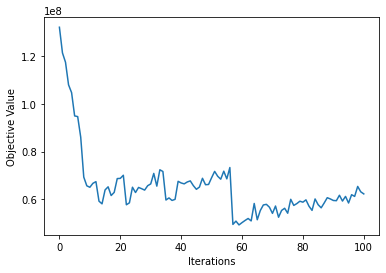

In [8]:

print('Z = ',Z)
print('====================================')
print('Zbar = ',Zbar_Matrix)
print('====================================')
print('Y = ',Y)
print('====================================')
print('ModelCoef = ',ModelCoef)
print('====================================')

print('Proposed Links: ', Y[np.where(Z == np.amin(Z))[0][0]][:len(NewLinkIds)])
print('NewLinkIds      ',NewLinkIds)
plt.plot(Z)
plt.xlabel('Iterations') 
plt.ylabel('Objective Value') 
plt.show()


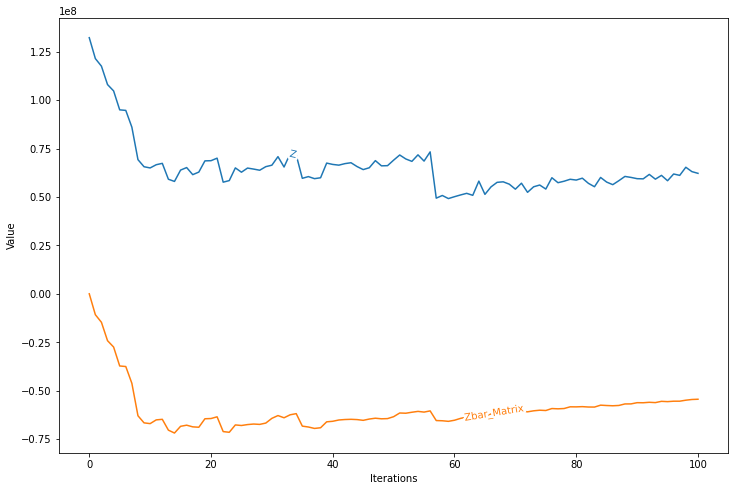

In [9]:
#--رسم نمودار مقادیر z ,Zbar
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(range(len(Z)), Z, label = 'Z', linestyle="-")
plt.plot(range(len(Zbar_Matrix)), Zbar_Matrix, label = 'Zbar_Matrix', linestyle="-")
plt.xlabel('Iterations') 
plt.ylabel('Value' )
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.show()

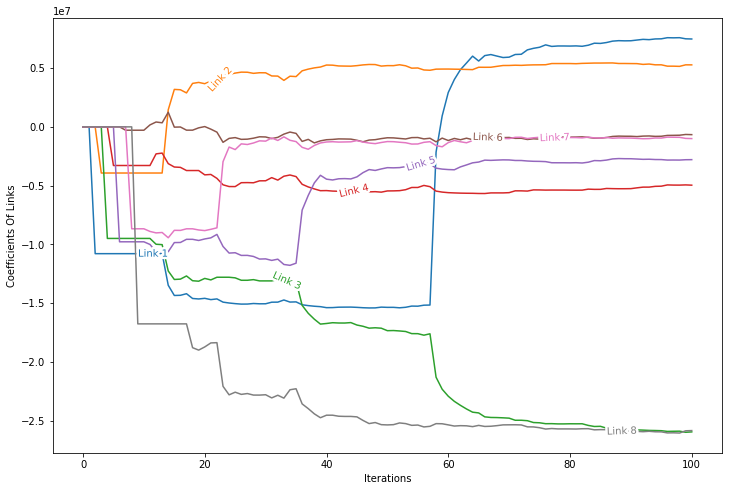

In [10]:
#رسم نمودارهای ضرایب لینکها در رگرسیون در تکرارهای مختلف
plt.rcParams['figure.figsize'] = [12, 8]
for i in range(i):
    plt.plot(range(len(ModelCoef[:,i])), ModelCoef[:,i], label = 'Link ' + str(i + 1), linestyle="-")
    plt.xlabel('Iterations') 
    plt.ylabel('Coefficients Of Links' )
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.show()

ProgramRuningTime:  7247.008067
TAPRuningTimeTotal =  4589.302443000001
LinearRegressionRuningTimeTotal =  0.053857999999999996
LIPRuningTimeAllTotal =  11.380417


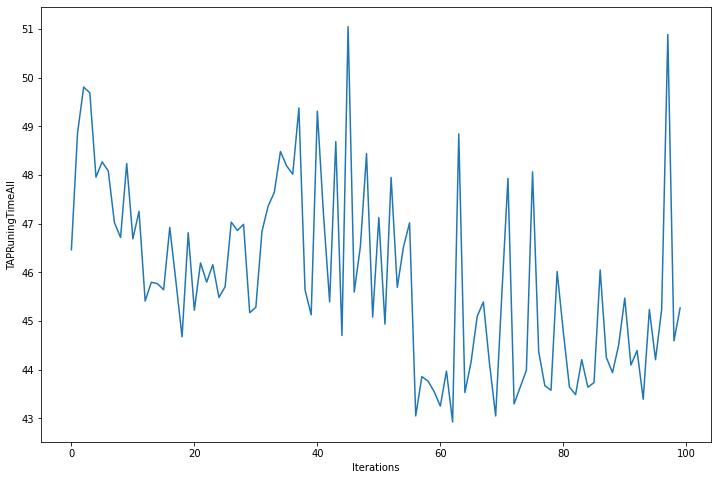

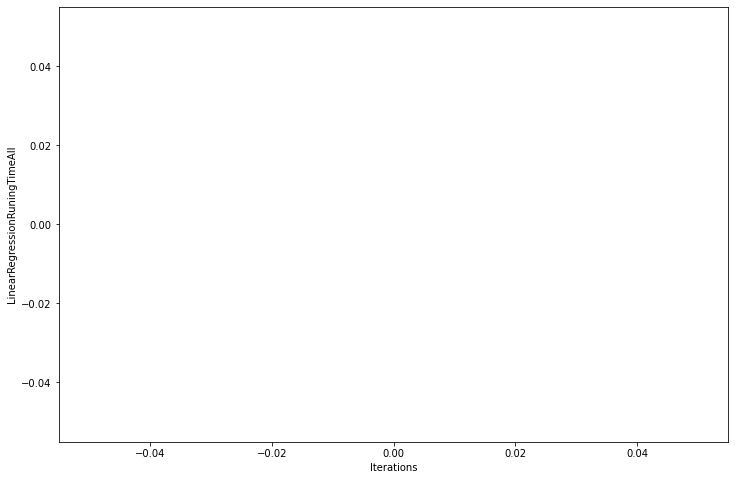

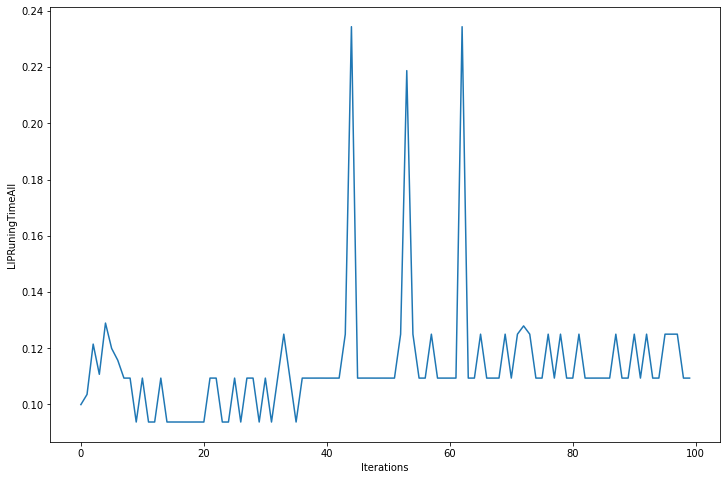

In [11]:
#نمودارهای زمان اجرای قسمتهای مختلف کد
print('ProgramRuningTime: ', (PrgFinishTime - PrgStartTime).total_seconds())  

TAPRuningTimeTotal = sum(TAPRuningTimeAll)
print('TAPRuningTimeTotal = ',TAPRuningTimeTotal)

LinearRegressionRuningTimeTotal = sum(LinearRegressionRuningTimeAll)
print('LinearRegressionRuningTimeTotal = ',LinearRegressionRuningTimeTotal)

LIPRuningTimeAllTotal = sum(LIPRuningTimeAll)
print('LIPRuningTimeAllTotal = ',LIPRuningTimeAllTotal)

plt.plot(TAPRuningTimeAll)
plt.xlabel('Iterations') 
plt.ylabel('TAPRuningTimeAll') 
plt.show()

plt.plot()
plt.xlabel('Iterations') 
plt.ylabel('LinearRegressionRuningTimeAll') 
plt.show()

plt.plot(LIPRuningTimeAll)
plt.xlabel('Iterations') 
plt.ylabel('LIPRuningTimeAll') 
plt.show()
